# 7. Vorlesung Nichtlineare Regelungstechnik 1

## Vorlesungsbeispiel zur Gleitregime-Regelung (Sliding-Mode-Control)

System:

\begin{align*}
\dot x_1(t) &= x_2\\
\dot x_2(t) &= -a(t) \dot x_2^2(t) \cos(3 x_1(t)) + u(t)
\end{align*}

wobei über $a(t)$ nur bekannt ist $1 < a(t) < 2$. Hierfür ist ein Gleitregime-Regler zu entwerfen, der den Ausgang $y = x_1$ einer vorgegebenen Referenztrajektorie $t \mapsto y_{ref}(t)$ nachführt, ohne dass der genaue Verlauf von $a(t)$ bekannt ist.

### Hinweise

Zu diesem Notebook gibt es noch zwei weitere:

- `nl1-v7-01-slidingmode-beispiel`: Lösung der Grundaufgabe, ohne Abschätzungen
- `nl1-v7-02-slidingmode-beispiel`: Erweiterung um Unbestimmtheiten im Systemmodell und Anti-Klapper-Vorrichtung

### Lösung

- Definition der Gleitfläche: 
  \begin{equation*}
  s(\tilde x_1, \tilde x_2) = \tilde x_2 + \lambda\tilde  x_1 \qquad \text{mit} \qquad \lambda > 0, \, \tilde x_i =  x_i - x_{i,ref}, \, i=1,2
  \end{equation*}
  
  Es gilt:
  \begin{equation*}
  \dot s(\tilde x_1, \tilde x_2) = \dot{\tilde x}_2 + \lambda \dot{\tilde x}_1 = -a(t) x_2^2 \cos(3 x_1) - \dot x_{2,ref} + u + \lambda (x_2 - x_{2,ref})
  \end{equation*}
  
- Gleitbedingung:
  \begin{equation*}
  \frac{1}{2} \frac{\text{d}}{\text{d}t} \left(s^2\right) =  s \dot s \stackrel{!}{\leq} \eta |s|
  \end{equation*}
  
  Mit dem Ausdruck für $\dot s$ ergibt sich:
  \begin{align*}
  -a(t)x_2^2 \cos(3 x_1) - \dot x_{2,ref} + u + \lambda (x_2 - x_{2,ref}) \quad &
  \begin{cases}
  \stackrel{!}{\leq} - \eta &\text{für} \, s > 0\\
  \stackrel{!}{\geq} \hphantom{-} \eta &\text{für} \, s < 0
  \end{cases}\\
  u \quad &
  \begin{cases}
  \stackrel{!}{\leq} - \eta + a(t) x_2^2 \cos(3 x_1) + \dot x_{2,ref} - \lambda (x_2 - x_{2, ref}) &\text{für} \, s > 0\\
  \stackrel{!}{\geq} \hphantom{-} \eta + a(t) x_2^2 \cos(3 x_1) + \dot x_{2,ref} - \lambda (x_2 - x_{2, ref})  &\text{für} \, s < 0
  \end{cases}
  \end{align*}

  Da $a(t)$ nicht genau bekannt, erfolgt jetzt eine worst-case-Abschätzung:
  \begin{align*}
  u \quad &
  \begin{cases}
  \stackrel{!}{\leq} - \eta - 2 x_2^2 |\cos(3 x_1)| + \dot x_{2,ref} - \lambda (x_2 - x_{2, ref}) &\text{für} \, s > 0\\
  \stackrel{!}{\geq} \hphantom{-} \eta + 2 x_2^2 |\cos(3 x_1)| + \dot x_{2,ref} - \lambda (x_2 - x_{2, ref})  &\text{für} \, s < 0
  \end{cases}
  \end{align*}
  
- Resultierender Regler:
  \begin{equation*}
  u = -(\eta + 2 x_2^2 |\cos(3 x_1)|)\cdot \text{sgn}(s) + \dot x_{2,ref} - \lambda (x_2 - x_{2, ref})
  \end{equation*}

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/nl1-nbviewer-content

Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2022-2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>

---

## Vorbereitung der Simulation

### Import benötigter Module

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt

### Implementierung eines Referenztrajektoriengenerators

#### Vorüberlegungen

Im Regelgesetz wird $\dot x_{2,ref} = \ddot y_{ref}$ benötigt. Also muss die Funktion zur Beschreibung der Referenztrajektorie zweifach stetig differenzierbar sein. Realisiert wird ein Übergang von $y_a$ nach $y_b$ auf dem Zeitintervall $[t_a, t_b]$. Die Funktion wird wie folgt realisiert:

\begin{equation*}
y(t) = 
\begin{cases}
y_a &\text{für} \,t < t_a\\
y_a + (y_a - y_b) \cdot y_{proto}\left(\frac{t - t_a}{t_b - t_a}\right) & \text{für}\, t_a \leq t \leq t_b\\
y_b &\text{für}\, t > t_b
\end{cases}.
\end{equation*}

Besipielsweise gilt für die zweite Ableitung:
\begin{equation*}
\ddot y(t) = 
\begin{cases}
0 &\text{für} \,t < t_a\\
\frac{(y_a - y_b)}{(t_b - t_a)^2} \cdot y^{\prime\prime}_{proto}\left(\frac{t - t_a}{t_b - t_a}\right) & \text{für}\, t_a \leq t \leq t_b\\
0 &\text{für}\, t > t_b
\end{cases}.
\end{equation*}


Die Prototypenfunktion $y_{proto}$ realisiert einen Übergang von 0 auf 1 auf dem Zeitintervall [0, 1] und ist wie folgt definiert:

\begin{equation*}
y_{proto}(t) = c_0 + c_1 t  + c_2 t^2 + c_3 t^3 + c_4 t^4 + c_5 t^5.
\end{equation*}

Für die Ableitungen gilt:
\begin{align*}
\dot y_{proto}(t) &= c_1  + 2 c_2 t + 3 c_3 t^2 + 4 c_4 t^3 + 5 c_5 t^4\\
\ddot y_{proto}(t) &= 2 c_2 + 6 c_3 t + 12 c_4 t^2 + 20 c_5 t^3
\end{align*}

**Bestimmung der Koeffizienten der Protoypenfunktion:**

Es muss gelten: $y(0) = 0$, $\dot y(0) = 0$, $\ddot y(0) = 0$. Daraus folgt: $c_0 = 0$, $c_1 = 0$, $c_2 = 0$. An der Stelle $t = 1$ gilt:

\begin{align*}
c_3 + c_4 + c_5 &= 1\\
3 c_3 + 4 c_4 + 5 c_5 &= 0\\
6 c_3 + 12 c_4 + 20 c_5 &= 0
\end{align*}

also

\begin{equation*}
\begin{pmatrix}
1 &1 &1\\
3 &4 &5\\
6 &12 &20
\end{pmatrix}
\begin{pmatrix}
c_3 \\ c_4 \\ c_5
\end{pmatrix}
=
\begin{pmatrix}
1 \\ 0 \\ 0
\end{pmatrix}
\qquad
\Leftrightarrow
\qquad
\begin{pmatrix}
c_3 \\ c_4 \\ c_5
\end{pmatrix}
=
\begin{pmatrix}
1 &1 &1\\
3 &4 &5\\
6 &12 &20
\end{pmatrix}^{-1}
\begin{pmatrix}
1 \\ 0 \\ 0
\end{pmatrix}
= 
\begin{pmatrix}
40 \\ -15 \\ 6
\end{pmatrix}
\end{equation*}
Nachfolgend die entsprechende Rechnung:

In [2]:
np.linalg.solve(np.array([[1, 1, 1], [3, 4, 5], [6, 12, 20]]), np.array([[1], [0], [0]]))

array([[ 10.],
       [-15.],
       [  6.]])

#### Referenztrajektorien-Klasse

Die Instanzierung für einen Übergang von `ya` nach `yb` im Zeitintervall `[ta, tb]` lautet:

```python
ref_traj = RefTraj(ta, tb, ya, yb)
```

Und die Auswertung zum Zeitpunkt `t`:

```python
y_ref, ydot_ref, yddot_ref = ref_traj.eval(t)
```

**Bemerkung** Der `*`-Operator multipliziert numpy-Arrays elementweise.

In [3]:
class RefTraj(object):
    """
    Primitiver Referenztrajektoriengenerator für Übergang
    zwischen zwei Werten auf einem vorgegeben Intervall.
    Die Solltrajektorie ist zweimal stetig differenzierbar.
    """

    def __init__(self, t_start, t_end, y_start, y_end):
        """ 
        Instanzierung für den Übergang von y_start nach y_end
        auf dem Intervall [t_start, t_end]
        """
        self.t0 = t_start
        self.t1 = t_end
        self.dt = t_end - t_start
        self.y0 = y_start
        self.dy = y_end - y_start

    def eval(self, t):
        """
        Wertet Trajektorie zum Zeitpunkt t aus. 
        Gibt den Absolutwertwert und die Ableitungen in einem
        Array zurück.

        Geht nur für skalare Werte von t.
        """
        return np.array([self.y0, 0.0, 0.0]) + \
               np.array([self.dy, self.dy/self.dt, self.dy/self.dt**2]) * self.proto_y((t - self.t0) / self.dt)

    @classmethod
    def proto_y(cls, t):
        """
        Realisierung der Prototypenfunktion für den Übergang von 0 auf 1
        auf dem Zeitintervall [0, 1]. Als Klassenmethode definiert,
        da unabhängig von der konkreten Objektinstanz 
        (in C++ / Java: static method)
        """
        if t < 0:
            return np.array([0.0, 0.0, 0.0])
        elif t > 1:
            return np.array([1.0, 0.0, 0.0])
        else:
            return np.array([10 * t**3 - 15 * t**4 + 6 * t**5,     # y
                             30 * t**2 - 60 * t**3 + 30 * t**4,    # ydot
                             60 * t - 180 * t**2 + 120 * t**3])    # yddot

**Bemerkung:** In der Implementierung der `proto_y` Funktion im `else`-Zweig wurden die zugrundeliegenden Polynome direkt eingegeben, um zu veranschaulichen, was passiert. Viel effektiver wäre die Verwendung des Horner-Schemas.

#### Test des Referenztrajektoriengenerators

Text(0, 0.5, '$\\ddot y$')

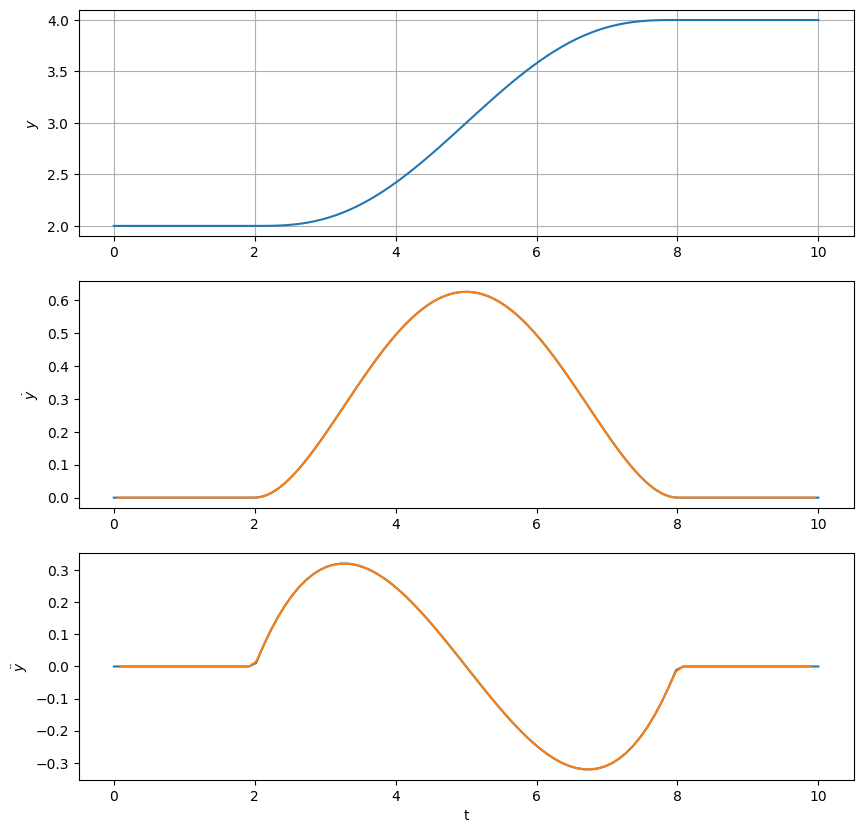

In [4]:
t = np.linspace(0, 10, 100)
ref_traj = RefTraj(2, 8, 2, 4)

y_ref = np.zeros_like(t)
yDot_ref = np.zeros_like(t)
yDDot_ref = np.zeros_like(t)
for i, t_val in enumerate(t):
    y_ref[i], yDot_ref[i], yDDot_ref[i] = ref_traj.eval(t_val)

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(t, y_ref)
plt.grid()
plt.ylabel('$y$')
plt.subplot(312)
plt.plot(t, yDot_ref, t[1:] - 0.5*t[1], np.diff(y_ref, n=1)/(t[1] - t[0]))
plt.ylabel('$\dot y$')
plt.subplot(313)
plt.plot(t, yDDot_ref, t[1:-1], np.diff(y_ref, n=2)/(t[1] - t[0])**2)
plt.xlabel('t')
plt.ylabel('$\ddot y$')

### Simulationsparameter

In [5]:
# Angaben für Referenztrajektorie
yref_a = 0
yref_b = 4
tref_a = 0
tref_b = 20

# Simulationsdauer
t_sim = 30

# Abtastzeit Regler
t_sample = 0.1

# Anzahl der Auswertungen des zeitkont. Systems zwischen den Abtastschritten
refine_factor = 10

### Reglerparameter

Um das Klappern zu unterdrücken bzw. abzumildern kann `anti_chatter` auf `True` gesetzt werden. Dann wird im Regelgesetz statt der Signum-Funktion die Sättigungsfunktion mit dem Band $ \pm \epsilon$ (Parameter `chatter_band`) verwendet.

In [6]:
# Regler
plambda = 2
peta = 1

# Anti-Klapper-Vorrichtung (hemdsärmelig)
anti_chatter = False
chatter_band = 0.2

## Definition benötigter Funktionen

### Funktion $a(t)$ in der Systemdgl.

Erhöhen Sie die Amplitude deutlich, um die Robustheit des Entwurfs zu testen

In [7]:
def a_func(t):
    """
    Implementation der Funktion a(t) der Systemdynamik
    """
    #return 2 * np.ones_like(t)
    return 0.5 * np.sin(t) + 1.5

### Rechte Seite des Systemdifferenzialgleichungssystems

In [8]:
def dgl_sys(t, x, u):
    """
    Implementation der rechten Seite des Differenzialgleichungssystems
    """
    x1, x2 = x

    x1_dot = x2
    x2_dot = a_func(t) * x2**2 * np.cos(3 * x1) + u

    return [x1_dot, x2_dot]

### Definition des Stop-Events

Da der Regler das System bei Betrieb außerhalb der Spezifikation ggf. nicht stabilisieren kann, muss die Simulation in diesen Fällen abgebrochen werden. Ansonsten werden die Werte der Zustandskomponenten so groß, dass man auf dem Plot nichts erkennen kann. Hierzu wird dem Gleichungslöser diese Funktion übergeben, die ein Stop-Ereignis aulöst, sobald der Abstand des Zustands zum Ursprung größer ist als 10.

<div class="alert alert-block alert-info">
    <b>Tip:</b> Schauen Sie in der <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html>Dokumentation des Dgl-Lösers</a> nach, um sich genauer zu informieren. In Matlab ist unter dem Sichwort <a href=https://www.mathworks.com/help/matlab/math/ode-event-location.html>ode event</a> nachzusehen.
</div>

In [9]:
def stop_event(t, x):
    """
    Ereignisfunktion zum Anhalten der Simulation, falls Abstand der
    Zustandstrajektorie zum Ursprung größer als 10
    """
    return np.linalg.norm(x) - 20


# Attribute, die der obigen Funktion übergeben werden können (Python-Spezialität)
stop_event.terminal = True  # Im Ereignisfall anhalten
stop_event.direction = 1    # Wenn norm(x) - 10 größer Null wird

### Regelgesetz 1 (mit Klappern)

In [10]:
def sliding_mode_controller(t, x, para_lambda, para_eta, ref_traj):
    """
    Implementierung des Regelgesetzes unter der Annahme, dass a(t) < amax
    """
    x1, x2 = x
    x1_ref, x2_ref, x2Dot_ref = ref_traj.eval(t)  # gibt y_ref, y_ref_dot, y_ref_ddot zurück

    s = x2 - x2_ref + para_lambda * (x1 - x1_ref)

    return -(para_eta + 2 * x2**2 * np.abs(np.cos(3 * x1))) * np.sign(s) + x2Dot_ref - para_lambda * (x2 - x2_ref)

### Regelgesetz 2 (ohne Klappern)

Die Sättigungsfunktion wird über die Funktion [np.clip()](https://numpy.org/doc/stable/reference/generated/numpy.clip.html) realisiert.

```python
(1 / eps) * np.clip(y, -eps, eps)
```

sorgt dafür, dass `y` im Intervall `[-eps, eps]` von -1 bis 1 durchläuft.

In [11]:
def sliding_mode_controller_nochatter(t, x, para_lambda, para_eta, para_eps, ref_traj):
    """
    Implementierung des Regelgesetzes unter der Annahme, dass a(t) < amax
    """
    assert para_eps > 0, "para_eps muss größer Null sein!"

    x1, x2 = x
    x1_ref, x2_ref, x2Dot_ref = ref_traj.eval(t)  # gibt y_ref. y_ref_dot, y_ref_ddot zurück

    s = x2 - x2_ref + para_lambda * (x1 - x1_ref)

    sat = (1 / para_eps) * np.clip(s, -para_eps, para_eps)

    return -(para_eta + 2 * x2**2 * np.abs(np.cos(3 * x1))) * sat  + x2Dot_ref - para_lambda * (x2 - x2_ref)

## Durchführung der Simulation

In [12]:
ref_traj = RefTraj(tref_a, tref_b, yref_a, yref_b)

t_control_steps = np.arange(0, t_sim + t_sample, t_sample)
x_control_steps = np.zeros((2, t_control_steps.size))  # 2 Zeilen, soviel Spalten wie Schritte
u_control_steps = np.zeros(t_control_steps.size)

t_cont = np.array([])
x_cont = np.ndarray((2, 0))

x_act = ref_traj.eval(0)[0:2] # + np.array([1, 0]) # <- entkommentieren für Simulation mit Anfangsfehler

In [13]:
for i, t_act in enumerate(t_control_steps):
    x_control_steps[:, i] = x_act

    if anti_chatter:
        u_act = sliding_mode_controller_nochatter(t_act, x_act, plambda, peta, chatter_band, ref_traj)
    else:
        u_act = sliding_mode_controller(t_act, x_act, plambda, peta, ref_traj)
    u_control_steps[i] = u_act

    sol = sci.solve_ivp(lambda t, x: dgl_sys(t, x, u_act), [t_act, t_act + t_sample], x_act, 
                        t_eval=np.linspace(t_act, t_act + t_sample, refine_factor), 
                        events=[stop_event])

    # Ein Status ungleich null bedeutet, dass das Stop-Event ausgelöst wurde.
    if sol.status != 0:
        print("Simulation wegen mutmaßlicher Instabilität abgebrochen bei t = {} s".format(sol.t_events[0][0]))
        break

    x_act = sol.y[:, -1]

    t_cont = np.hstack((t_cont, sol.t[0:-1]))
    x_cont = np.hstack((x_cont, sol.y[:,0:-1]))

y_ref = np.zeros((3, t_cont.size))
for i, t_act in enumerate(t_cont):
    y_ref[:, i] = ref_traj.eval(t_act)

## Darstellung der Ergebnisse

Trajektorie in der $x_1$-$x_2$-Ebene. Die roten Punkte markieren die Stellen, an den die Stellgröße neu berechnet wurde. Die durchgezogene gebogene Linie ist die Referenztrajektorie. Die Gleitfläche ist hier zeitvariant (!), darum ist sie nicht abgebildet.

`%matplotlib widget` entkommentieren für bessere Grafiken (erfordert ipywidgets)

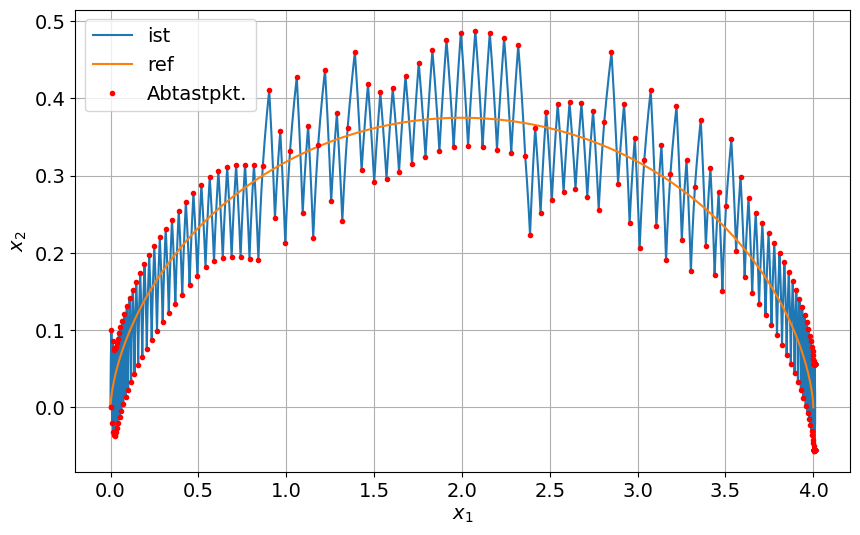

In [14]:
#%matplotlib widget
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(10, 6))

# Trajektorie Zustand
plt.plot(x_cont[0, :], x_cont[1, :], label='ist')

# Referenztrajektorie
plt.plot(y_ref[0, :], y_ref[1, :], label='ref')

# Abtastpunkte
plt.plot(x_control_steps[0, :], x_control_steps[1, :], '.', color='r', label='Abtastpkt.')

plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

Zeitverläufe

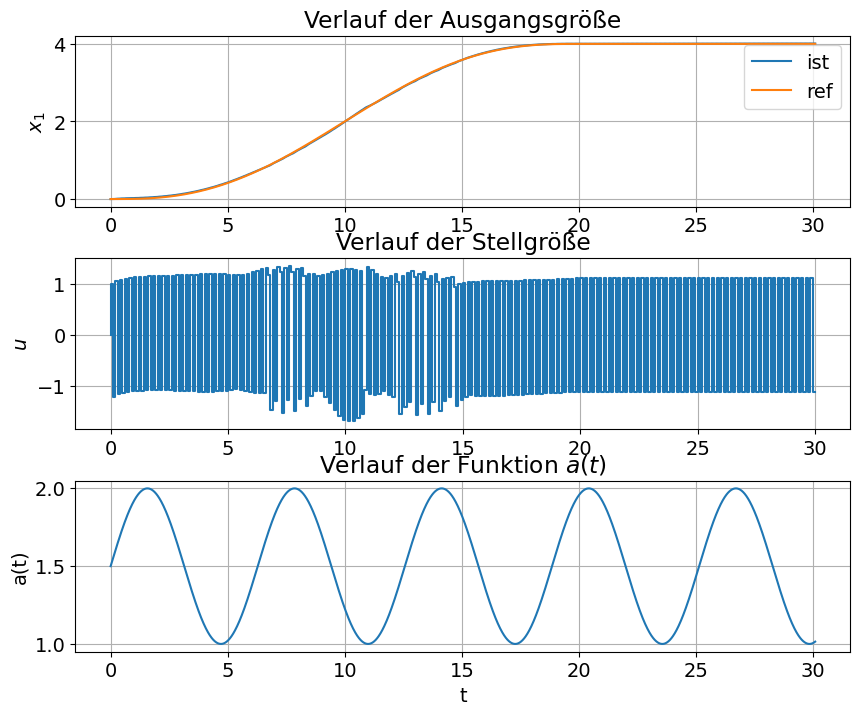

In [15]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(t_cont, x_cont[0,:], label="ist")
plt.plot(t_cont, y_ref[0, :], label="ref")
plt.title('Verlauf der Ausgangsgröße')
plt.ylabel('$x_1$')
plt.grid()
plt.legend()

plt.subplot(312)
plt.step(t_control_steps, u_control_steps)
plt.title('Verlauf der Stellgröße')
plt.ylabel('$u$')
plt.grid()

plt.subplot(313)
plt.plot(t_cont, a_func(t_cont))
plt.title('Verlauf der Funktion $a(t)$')
plt.grid()
plt.xlabel('t')
plt.ylabel('a(t)')

fig.subplots_adjust(hspace=0.3)
